In [73]:
import string
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

import pandas as pd
import matplotlib.pyplot as plt

In [74]:
print string.punctuation
print stopwords.words('english')[:10]

!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~
[u'i', u'me', u'my', u'myself', u'we', u'our', u'ours', u'ourselves', u'you', u"you're"]


In [85]:
# other techniques of tokenization are stemmers (reduce words to it's root (ran, running, runner ==> run))
# or categorization on verbds, adj...
def tokenize_text(document):
    stemmer = PorterStemmer()

    # Check characters to see if they are in punctuation
    no_punc = [char for char in document if char not in string.punctuation]

    # Join the characters again to form the string.
    no_punc = ''.join(no_punc)
    
    # remove capital letters
    no_upper = [word.lower() for word in no_punc.split()]
    
    # Now just remove any stopwords
    no_stopwords = [word for word in no_upper if word.lower() not in stopwords.words('english')]
    
    # stemmer
    #stemmed = [stemmer.stem(word) for word in no_stopwords]
    
    return no_stopwords

In [76]:
df = pd.read_csv('smsspamcollection/SMSSpamCollection', sep='\t',
                           names=["label", "message"])
df.head()

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


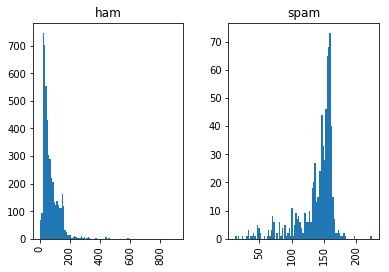

In [77]:
df['message'].apply(len).hist(bins=100, by=df['label'])
plt.show()

In [87]:
print 'original: ', df['message'][4]
print 'tokenized: ', tokenize_text(df['message'][4])

original:  Nah I don't think he goes to usf, he lives around here though
tokenized:  ['nah', 'dont', 'think', 'goes', 'usf', 'lives', 'around', 'though']


## bag of words

In [93]:
from sklearn.feature_extraction.text import CountVectorizer

bag_of_words_model = CountVectorizer(analyzer=tokenize_text).fit(df['message'])

# Print total number of vocab words
print(len(bag_of_words_model.vocabulary_))

/home/marcroig/mlenv/lib/python2.7/site-packages/ipykernel_launcher.py:16: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  app.launch_new_instance()


9532


In [94]:
bag_of_words = bag_of_words_model.transform(messages['message'])
print('Shape of Sparse Matrix: ', bag_of_words.shape)
print('Amount of Non-Zero occurences: ', bag_of_words.nnz)
sparsity = (100.0 * bag_of_words.nnz / (bag_of_words.shape[0] * bag_of_words.shape[1]))
print('sparsity: {}'.format((sparsity)))

/home/marcroig/mlenv/lib/python2.7/site-packages/ipykernel_launcher.py:16: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  app.launch_new_instance()


('Shape of Sparse Matrix: ', (5572, 9532))
('Amount of Non-Zero occurences: ', 50110)
sparsity: 0.0943472533219


## tf-idf

In [110]:
from sklearn.feature_extraction.text import TfidfTransformer

tfidf_transformer = TfidfTransformer().fit(bag_of_words)
tfidf = tfidf_transformer.transform(bag_of_words)
print(tfidf.shape)

(5572, 9532)


## Classificator

In [106]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report

spam_detect_model = MultinomialNB().fit(tfidf, messages['label'])
all_predictions = spam_detect_model.predict(tfidf)
print (classification_report(df['label'], all_predictions))

             precision    recall  f1-score   support

        ham       0.97      1.00      0.99      4825
       spam       1.00      0.83      0.91       747

avg / total       0.98      0.98      0.98      5572



## FULL PROCESSING WITH TRAIN AND TEST

In [107]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df['message'], df['label'], test_size=0.2)


pipeline = Pipeline([
    ('bag of words', CountVectorizer(analyzer=tokenize_text)),  # strings to token integer counts
    ('tfidf', TfidfTransformer()),  # integer counts to weighted TF-IDF scores
    ('classifier', MultinomialNB()),  # train on TF-IDF vectors w/ Naive Bayes classifier
])

In [108]:
pipeline.fit(X_train,y_train)

/home/marcroig/mlenv/lib/python2.7/site-packages/ipykernel_launcher.py:16: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  app.launch_new_instance()


Pipeline(memory=None,
     steps=[('bag of words', CountVectorizer(analyzer=<function tokenize_text at 0x7fb414d31230>,
        binary=False, decode_error=u'strict', dtype=<type 'numpy.int64'>,
        encoding=u'utf-8', input=u'content', lowercase=True, max_df=1.0,
        max_features=None, min_df=1, ngram_range=(1, 1), pre...         use_idf=True)), ('classifier', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))])

In [109]:
predictions = pipeline.predict(X_test)
print(classification_report(predictions,y_test))

/home/marcroig/mlenv/lib/python2.7/site-packages/ipykernel_launcher.py:16: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  app.launch_new_instance()


             precision    recall  f1-score   support

        ham       1.00      0.96      0.98      1007
       spam       0.72      1.00      0.83       108

avg / total       0.97      0.96      0.96      1115



A spam classifier has been built with a precision of 72% on finding spam messages. The system is very simple and straighforward, in order to improve the detection rates some changes are needed. Better text preprocessing, take into account the lenght of the messages, hyperparameter tunning or experiment with other classifiers (as SVM or random forest)